In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import gamma

from utils import SpinChain

### Homogeneous XX chain

The homogeneous chain chain studied in [1] has constant exchange integrals $J_n=J\in\mathbb{R}$ and constant magnetic field $h_n=h\in\mathbb{R}$.

#### 1. Diagonalisation

If we considered periodic boundary conditions, the system would be invariant under translations (all sites on the chain would look the same). Translational invariance would imply momentum conservation via Noether's theorem, therefore we should work in the momentum (Fourier) basis.

$$
\tilde{a}_k = \frac{1}{\sqrt{N}}\sum\limits_{n=0}^{N-1} a_n e^{-i\frac{2\pi}{N}nk}
$$

So $E=\Phi^\dagger H^1\Phi$, with the diagonalisation being $\Phi_{nk}=\frac{1}{\sqrt{N}}e^{-i\frac{2\pi}{N}nk}$. Let's naively apply this diagonalisation to the $H^1$ matrix with free boundary conditions:

$$
\sum\limits_{n=0}^{N-1}\sum\limits_{m=0}^{N-1}\Phi^\dagger_{jn} H^1_{nm} \Phi_{mk} = 
\frac{1}{N}\sum\limits_{n=0}^{N-1}\sum\limits_{m=0}^{N-1}e^{i\frac{2\pi}{N}jn}e^{-i\frac{2\pi}{N}mk}(J\delta_{n+1,m}+J\delta_{n-1,m}+h\delta_{nm}) =
$$

$$
= \frac{1}{N}\left(
(e^{i\frac{2\pi}{N}k}+e^{-i\frac{2\pi}{N}k})J\sum\limits_{n=0}^{N-2}e^{i\frac{2\pi}{N}n(j-k)}+
h\sum\limits_{n=0}^{N-1}e^{i\frac{2\pi}{N}n(j-k)}
\right) =
$$

$$
= \left(2\cos\left(\frac{2\pi k}{N}\right)J+h\right)\delta_{jk}+ O\left(\frac{1}{N}\right)
$$

$$
\boxed{
\begin{aligned}
    H&\approx\sum\limits_{k=0}^{N-1}\varepsilon_k\tilde{a}^\dagger_k\tilde{a}_k, &
    \varepsilon_k&\approx2\cos\left(\frac{2\pi k}{N}\right)J+h
\end{aligned}
}
$$

This diagonalisation still works for the open chain when $N\rightarrow\infty$. With a little bit more work we could find an exact solution for the open chain, but this suffices as a simple example which solves both boundary conditions in the thermodynamic limit.

Text(0, 0.5, 'max |off diagonal|')

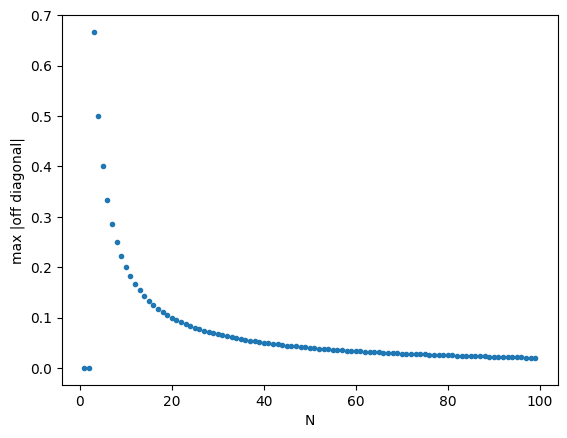

In [4]:
# Numerical test
@np.vectorize()
def offdiag_max(N, J, h):
    H1 = h * np.diag(np.ones(N)) + J * (np.diag(np.ones(N-1), k=1) + np.diag(np.ones(N-1), k=-1))
    FT = np.fft.fft(np.eye(N), norm='ortho') # Fourier transform matrix
    E = np.conj(FT) @ H1 @ FT 
    return np.max(np.abs(E-np.diag(np.diag(E))))

Nmax = 100
J = 1
h = 2

N = np.arange(1, Nmax)
o = offdiag_max(N, J, h)
plt.plot(N, o, '.')
plt.xlabel('N')
plt.ylabel(r'max |off diagonal|')

We can now easily determine the ground state. It will include all excitations with $\varepsilon_n<0$, therefore we only find modes with

$$
- \left(\frac{h}{J}\right) > 2\cos\left(\frac{2\pi k}{N}\right)
$$

Or, in other words

$$
\begin{aligned}
k_c \leq k \leq N - k_c, & & k_c &= \left\lceil\frac{N}{2\pi}\arccos\left(\frac{-h}{2J} \right)\right\rceil
\end{aligned}
$$

We then realise that if $h/J>2$ (the magnetic field is strong), the ground state is the vacuum $|0\rangle$ (all spins up). Similarly, for a strong magnetic field in the opposite direction, the ground state would excite all modes (all spins down).

For $|h/J|<2$ we have some intermediate occupation and the system is gapless &mdash; more generally, inhomogeneous chains are also gapless at intermediate filling $0<M/N<1$. Since there's no minimum "cost" to excite the system,  its behaviour doesn't depend on a specific energy or length scale. This scale invariance is related to a conformal symmetry and associated $(1+1)-$ dimensional conformal field theory (CFT) [3].

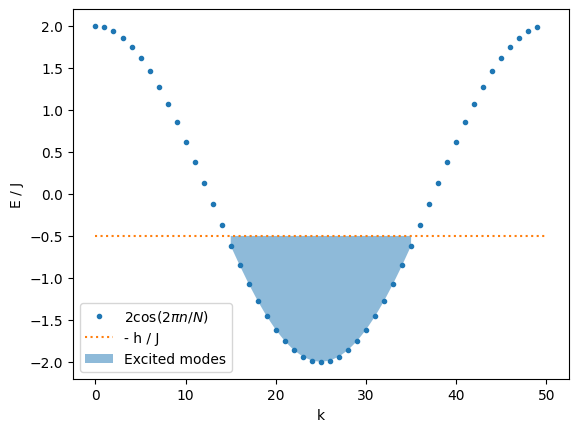

In [3]:
# Let's visualise this
N = 50
J = 2
h = 1

kc = int(np.ceil(N * np.arccos(- h / (2*J)) / (2 * np.pi)))
k = np.linspace(0, N-1, N)
osc = 2 * np.cos(2 * np.pi * k / N)
plt.plot(k, osc, '.')
plt.plot([0, N], [-h/J, -h/J], ':')
plt.fill_between(k[kc:N-kc+1], osc[kc:N-kc+1], - h / J, alpha=.5)
plt.xlabel('k')
plt.ylabel('E / J')
plt.legend(['$2\cos(2\pi n/N)$', '- h / J', 'Excited modes'])

#### 2. Correlation Matrix

Now the system has been diagonalised, we can calculate its correlation matrix:

$$
C_{nm} = \sum_{k=N/2-M/2}^{N/2+M/2} \Phi_{nk} \Phi^*_{mk}
 = \frac{1}{N} \sum_{k=-M/2}^{M/2} e^{-i\frac{2\pi}{N}(k+N/2)(n-m)} =
$$

$$
=  \frac{1}{N} \sum_{k=-M/2}^{M/2} \cos\left(\pi\left(\frac{2k}{N}+1\right)(n-m)\right) = 
(-1)^{n-m} \frac{2}{N} \sum_{k=0}^{M/2} \cos\left(\frac{2\pi k}{N}(n-m)\right)
$$

And in the thermodynamic limit

$$
C_{nm} \approx 2(-1)^{n-m} \int_0^{M/2N} \mathrm{d}x \cos(2\pi x(n-m)) = 
\boxed{(-1)^{n-m}\frac{M}{N}\mathrm{sinc}\left(\frac{\pi M}{N}(n-m)\right)}
$$

Let's verify this.

Text(0, 0.5, 'max |C$_{the}$ - C$_{num}$|')

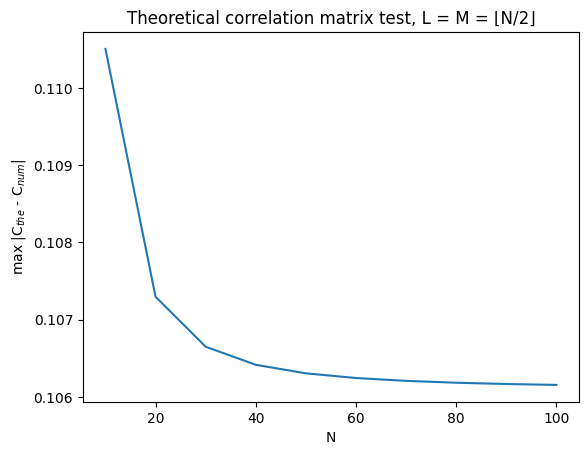

In [12]:
# Homogeneous chain correlation matrix
def corr_homogeneous(N, L, M):
    C = np.empty((L, L))
    for n in range(L):
        for m in range(L):
            C[n, m] = (-1)**(n-m) * M/N * np.sinc(M/N*(n-m))
    return C

# Test
N = np.arange(10, 101, 10)
J = 2
h = -1

@np.vectorize
def error(N, J, h):
    C_the = corr_homogeneous(N, L=N//2, M=N//2)
    homogeneous_chain = SpinChain(N, J * np.ones(N-1), h * np.ones(N))
    homogeneous_chain.set_filling(N//2)
    C_num = homogeneous_chain.correlation_matrix(N//2)
    return np.max(np.abs(C_the - np.array(C_num.tolist())))

err = error(N, J, h)
plt.plot(N, err)
plt.title('Theoretical correlation matrix test, L = M = ⌊N/2⌋')
plt.xlabel('N')
plt.ylabel('max |C$_{the}$ - C$_{num}$|')

#### 3. Entanglement Entropy

So now all that remains is calculating the entanglement entropy. The procedure described in Refs. [1], [4] is rather involved. One starts by defining

$$
D(\mu) = \mathrm{det}(\mu I - C) = \prod_{i=0}^{L-1} (\mu - \nu_i)
$$

The Fisher-Hartwig conjecture provides an asymptotic expression for $D(\mu)$, which can be plugged into Cauchy's integral formula:

$$
S = \sum\limits_{i=0}^{L-1}e(1+\epsilon, \nu_i) = 
\sum\limits_{i=0}^{L-1}\frac{1}{2\pi i}\oint_{c(\epsilon,\delta)} \frac{e(1+\epsilon,\mu)}{\mu-\nu_i}\mathrm{d}\mu =
\frac{1}{2\pi i}\oint_{c(\epsilon,\delta)} e(1+\epsilon,\mu)\ \mathrm{d}(\log D(\mu))
$$

Here $e(1+\epsilon,\mu)$ is an analytic function such that $e(1, \nu_i)=s^{(2)}(\nu_i)$, and $c(\epsilon, \delta)$ is a dumbbell-shaped contour enclosing all eigenvalues $\nu_i$ on the real line [4]. We then take $\epsilon,\delta\rightarrow0^+$.

Finally, for a system filled up to $M=k_c$, ref. [1] presents the analytical result for the von Neumann entropy. Ref. [3] however presents a more complete result. If we define $\lambda=\lim\limits_{N\rightarrow\infty} L/N$, the size of the studied block of particles relative to the entire system, the Rényi entropy at arbitrary filling for open boundary conditions is given by

$$
S_\alpha(N,\lambda) = \frac{c}{12}(1+\alpha^{-1})\log f(N,\lambda) + c'_\alpha +
\begin{cases}
O(N^{-1}), 
\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad \alpha<1 \\
\mu_\alpha\sin(\pi(2L+1)k_F) f(N, \lambda)^{-1/\alpha} + o(N^{-1/\alpha}),
\quad \alpha\geq1
\end{cases}
$$

There are many important points to discuss:

- $c$ is the central charge of the CFT related to the spin chain, which determines the model's universality class. For the homogeneous Heisenberg chain $c=1$.

- $c'_\alpha = \frac{1}{2}(1+\alpha^{-1})\left\{\frac{\log2}{3} + \int_0^\infty\left[\frac{\mathrm{csch}\ t}{1-\alpha^{-2}}(\alpha^{-1}\mathrm{csch}(t/\alpha)-\mathrm{csch}\ t)-\frac{e^{-2t}}{6} \right]\frac{\mathrm{d}t}{t} \right\}, $ 

&emsp;&emsp; noting that 

$$\lim\limits_{\alpha\rightarrow1}\frac{\mathrm{csch}\ t}{1-\alpha^{-2}}(\alpha^{-1}\mathrm{csch}(t/\alpha)-\mathrm{csch}\ t) = \frac{1}{2}(t\ \mathrm{coth}\ t-1)\mathrm{csch}^2 t, $$ 

&emsp;&emsp; a long formula but nothing special. It is a non-universal constant [3].

- $k_F = M/N$ is the Fermi momentum, given by the last filled energy level.

- $f(N, \lambda)=\frac{N}{\pi}\sin(\pi\lambda)\sin(\pi k_F)$

- $\mu_\alpha = \frac{2^{1-\frac{2}{\alpha}}}{1-\alpha}\frac{\Gamma(\frac{1}{2}+\frac{1}{2\alpha})}{\Gamma(\frac{1}{2}-\frac{1}{2\alpha})},\quad\lim\limits_{\alpha\rightarrow1}\mu_\alpha=-\frac{1}{4}$

- $\sin(\pi (2L+1)k_F)$ produces parity oscillations, which for large $\alpha$ can obscure the leading asymptotic terms [3].

This result is important. Not only does it solve the problem for the homogeneous chain, but it allows us to guess the shape of $S_\alpha$ for inhomogeneous chains under certain conditions.

Text(0, 0.5, '$S_\\alpha$')

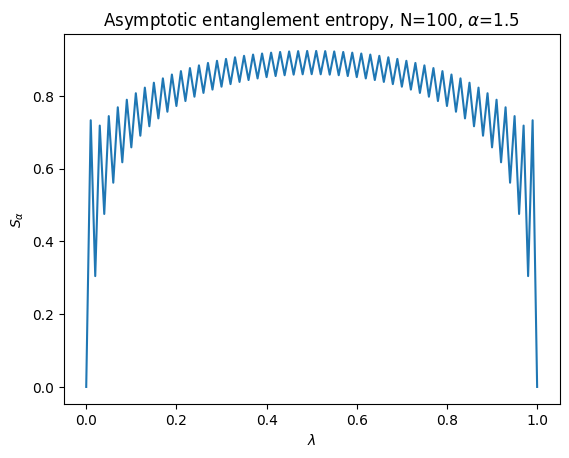

In [7]:
# Non-universal constant
def cp(a):
    # Integral for a = 1
    if np.isclose(a, 1):
        f1 = lambda t: (.5 * (t / np.tanh(t) - 1) / np.sinh(t) ** 2 - np.exp(-2*t)/6) / t
        integral = quad(f1, 0, np.inf, epsabs=np.inf)[0]
    # Integral for a =/= 1
    else:
        fa = lambda t: ((1 / (a*np.sinh(t/a)) - 1 / np.sinh(t)) / ((1-a**-2)*np.sinh(t)) - np.exp(-2*t)/6) / t
        integral = quad(fa, 0, np.inf, epsabs=np.inf)[0]
    # Constant
    cp = .5 * (1 + 1/a) * (np.log(2)/3 + integral)
    return cp

# f function
def f(N, lamb, kF):
    return N / np.pi * np.sin(np.pi*lamb) * np.sin(np.pi*kF)

# mu constant
def mu(a):
    if np.isclose(a, 1):
        return - .25
    return 2**(1 - 2/a) / (1 - a) * gamma(1/2 + 1/(2*a)) / gamma(1/2 - 1/(2*a))

# Asymptotic Rényi entropy
@np.vectorize()
def asymptotic_entropy(a, N, L, M):
    if np.isclose(L, 0) or np.isclose(L, N):
        return 0.
    lamb = L / N
    kF = M / N
    S = 1/12 * (1 + a**-1) * np.log(f(N, lamb, kF)) + cp(a)
    if a < 1:
        return S
    S += mu(a) * np.sin(np.pi * (2*L + 1) * kF) * f(N, lamb, kF) ** (-1/a)
    return S

# Example/test
a = 1.5
N = 100
L = np.arange(N+1)
M = N / 2

plt.plot(L / N, asymptotic_entropy(a, N, L, M))
plt.title(rf'Asymptotic entanglement entropy, N={N}, $\alpha$={a:.2e}'.rstrip('e+00'))
plt.xlabel('$\lambda$')
plt.ylabel(r'$S_\alpha$')

Calculating correlation matrix at filling 50/100... Done
Block L = 1, S = 0.69
Block L = 2, S = 0.38
Block L = 3, S = 0.72
Block L = 4, S = 0.51
Block L = 5, S = 0.75
Block L = 6, S = 0.58
Block L = 7, S = 0.77
Block L = 8, S = 0.63
Block L = 9, S = 0.79
Block L = 10, S = 0.67
Block L = 11, S = 0.81
Block L = 12, S = 0.70
Block L = 13, S = 0.83
Block L = 14, S = 0.72
Block L = 15, S = 0.84
Block L = 16, S = 0.74
Block L = 17, S = 0.85
Block L = 18, S = 0.76
Block L = 19, S = 0.86
Block L = 20, S = 0.78
Block L = 21, S = 0.87
Block L = 22, S = 0.79
Block L = 23, S = 0.88
Block L = 24, S = 0.80
Block L = 25, S = 0.89
Block L = 26, S = 0.81
Block L = 27, S = 0.89
Block L = 28, S = 0.82
Block L = 29, S = 0.90
Block L = 30, S = 0.83
Block L = 31, S = 0.90
Block L = 32, S = 0.84
Block L = 33, S = 0.91
Block L = 34, S = 0.84
Block L = 35, S = 0.91
Block L = 36, S = 0.85
Block L = 37, S = 0.92
Block L = 38, S = 0.85
Block L = 39, S = 0.92
Block L = 40, S = 0.85
Block L = 41, S = 0.92
Block L =

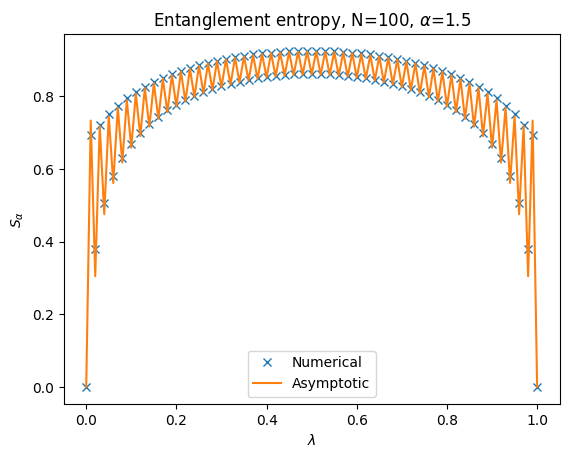

In [8]:
# Comparison of numerical solution against asymptotic solution 
N = 100
J = 2 * np.ones(N-1)
h = - np.zeros(N)
L = np.arange(N+1)
M = N//2
homogeneous_chain = SpinChain(N, J, h)
homogeneous_chain.set_filling(M)

a = 1.5
S_num = homogeneous_chain.renyi_entropy(a, L) 
S_asm = asymptotic_entropy(a, N, L, M)

plt.plot(L / N, S_num, 'x', label='Numerical')
plt.plot(L / N, S_asm, label='Asymptotic')
plt.title(rf'Entanglement entropy, N={N}, $\alpha$={a:.2e}'.rstrip('e+00'))
plt.xlabel('$\lambda$')
plt.ylabel(r'$S_\alpha$')
plt.legend()

### References

[1] Latorre, J., & Riera, A. (2009). A short review on entanglement in quantum spin systems. *Journal of Physics A: Mathematical and Theoretical, 42(50), 504002*. Retrieved from https://arxiv.org/abs/0906.1499

[2] Finkel, F., & González-López, A. (2020). Inhomogeneous XX spin chains and quasi-exactly solvable models. *Journal of Statistical Mechanics: Theory and Experiment, 2020(9), 093105*. Retrieved from https://arxiv.org/abs/2007.00369

[3] Finkel, F., & González-López, A. (2021). Entanglement entropy of inhomogeneous XX spin chains with algebraic interactions. *Journal of High Energy Physics, 2021(12)*. Retrieved from https://arxiv.org/abs/2107.12200

[4] Jin, B.Q., & Korepin, V. (2004). Quantum Spin Chain, Toeplitz Determinants and the Fisher–Hartwig Conjecture. *Journal of Statistical Physics, 116(1–4), 79–95*. Retrieved from https://arxiv.org/abs/quant-ph/0304108